In [11]:
library(gggenomes)
library(tibble)
library(tidyverse)
library(heatmaply)
library(jcolors)
library(grid) # for unit()
library(RColorBrewer)
library(reshape)
library(ggpubr)
library(splitstackshape)

In [12]:
locus_name<-c("HD", "PR")
strains<-c("76", "15", "19NSW04", "20QLD87")
full_name<-paste0("Pt",strains)
#Import mating type gene list
MAT_list<-read.table("MAT_list", header=FALSE, sep=" ")
colnames(MAT_list)<-c("MAT", "gene_id")
for (i in full_name){
    gff<-read.table(paste0("rename_gff/",i,".gff"), header=FALSE, sep="\t")%>%select(V1,V3,V4,V5,V7,V9)%>%filter(V3=="gene")
    colnames(gff)<-c("seq_id", "type", "start", "end", "strand", "feat_id")
    assign(paste0(i,"_gff"), gff)
}

In [13]:
HD_chr<-c("Pt76_chr4_A", "Pt15_chr3_A", "Pt19NSW04_chr4_C", "Pt20QLD87_chr4_C", "Pt76_chr4_B", "Pt15_chr3_B", "Pt19NSW04_chr4_B", "Pt20QLD87_chr4_D")
PR_chr<-c("Pt76_chr9_A", "Pt15_chr11_A", "Pt19NSW04_chr9_C", "Pt20QLD87_chr9_C", "Pt76_chr9_B", "Pt15_chr11_B", "Pt19NSW04_chr9_B", "Pt20QLD87_chr9_D")


In [14]:
get_flanking<-function(gff, gene, flank){
    #if featid dont have ; at the end, add it
    gene <- ifelse(substr(gene, nchar(gene), nchar(gene)) != ";", paste0(gene, ";"), gene)
    gff<-gff%>%mutate(feat_id=paste0(feat_id, ";"))
    indices <- grep(paste(gene, collapse = "|"), gff$feat_id, value = FALSE)
    for (i in indices){
        indices_before <-i-flank
        indices_after <-i+flank
        indices_range <-c(indices_before:indices_after)
        #append the indices_range to a new vector
        if (i==indices[1]){
            indices_all <-indices_range
        }else{
            indices_all <-c(indices_all, indices_range)
        }
    }
    indices_all<-unique(indices_all)
    result <- gff[indices_all, ]%>%mutate(feat_id=gsub(";","",feat_id))%>%mutate(type="CDS")%>%mutate(feat_id=gsub("Name=.*","",feat_id))
    return(result)
}

In [82]:
HD_list<-MAT_list%>%filter(grepl("HD", MAT))
STE3.2_list<-MAT_list%>%filter(grepl("STE3.2", MAT))
STE3.3_list<-MAT_list%>%filter(grepl("STE3.3", MAT))
PR_list<-rbind(STE3.2_list, STE3.3_list)
Annotation_gff<-rbind(Pt76_gff, Pt15_gff, Pt19NSW04_gff, Pt20QLD87_gff)
Annotation_gff<-Annotation_gff%>%mutate(start_tmp = start, end_tmp = end)%>%
                mutate(start = ifelse(seq_id=="Pt15_chr3_A", 8806656 - end_tmp, start),
                       end = ifelse(seq_id=="Pt15_chr3_A", 8806656 - start_tmp, end),
                       start = ifelse(seq_id=="Pt15_chr3_B", 8495914 - end_tmp, start),
                       end = ifelse(seq_id=="Pt15_chr3_B", 8495914 - start_tmp, end))%>%
                mutate(strand = ifelse(seq_id == "Pt15_chr3_A" | seq_id == "Pt15_chr3_B", ifelse(strand == "+", "-", "+"), strand))%>%
                select(-c(start_tmp, end_tmp))
Annotation_gff<-merge(Annotation_gff, MAT_list, by.x="feat_id", by.y="gene_id", all.x=TRUE)%>%arrange(seq_id, start)
#replace feat_id with MAT_gene name


In [682]:
blast <- read_feats("blast/Pt.o6")
colnames(blast) <- c("file_name", "feat_id", "feat_id2", "pident", "length", "mismatch", "gapopen", "start", "end", "start2", "end2", "evalue", "bitscore")
#colnames(blast)<-c("query", "subject", "identity", "length", "mismatch", "gapopen", "qstart", "qend", "sstart", "send", "evalue", "bitscore")
blast<-blast%>%filter(pident>=70)%>%mutate(feat_id=gsub("-T.*","",feat_id))%>%mutate(feat_id2=gsub("-T.*","",feat_id2))


Reading 'blast' with `read_blast()`:
* file_id: Pt [blast/Pt.o6]


In [17]:
coords_header<-c("start", "end", "start2", "end2", "LEN1", "LEN2", "IDY", "length", "length2", "COV_R", "COV_Q", "seq_id", "seq_id2")
read_coords<-function(file){
    coords<-read.table(file, skip=4, header=FALSE, sep="\t", row.names=NULL)
    colnames(coords)<-coords_header
    coords<-coords%>%filter(LEN1>=1000)%>%filter(LEN2>=1000)%>%filter(IDY>=90)
    coords<-coords%>%mutate(file_id="Pt")%>%mutate(strand=ifelse(start2<end2, "+", "-"))%>%select(file_id, seq_id, length, start, end, strand, seq_id2, length2, start2, end2)
    return(coords)
}

HD_coords <- read_coords("analysis/HD/Pt_HD.coords")
STE3.2_coords<- read_coords("analysis/PR/Pt_STE3.2.coords")
STE3.3_coords<- read_coords("analysis/PR/Pt_STE3.3.coords")
PR_coords<-rbind(STE3.2_coords, STE3.3_coords)

In [18]:
#Reverse chr3 coordinates for Pt15
HD_coords<-HD_coords %>%mutate(start_t=start, end_t=end, start2_t=start2, end2_t=end2)%>%
    mutate(start = ifelse(seq_id == "Pt15_chr3_A" | seq_id == "Pt15_chr3_B", length - end_t, start),
                 end = ifelse(seq_id == "Pt15_chr3_A" | seq_id == "Pt15_chr3_B", length - start_t, end),
                 strand = ifelse(seq_id == "Pt15_chr3_A" | seq_id == "Pt15_chr3_B", ifelse(strand == "+", "-", "+"), strand))
                 
HD_coords<-HD_coords %>%
    mutate(start2 = ifelse(seq_id2 == "Pt15_chr3_A" | seq_id2 == "Pt15_chr3_B", length2 - end2_t, start2),
                 end2 = ifelse(seq_id2 == "Pt15_chr3_A" | seq_id2 == "Pt15_chr3_B", length2 - start2_t, end2),
                 strand = ifelse(seq_id2 == "Pt15_chr3_A" | seq_id2 == "Pt15_chr3_B", ifelse(strand == "+", "-", "+"), strand))%>%
    select(-c(start_t, end_t, start2_t, end2_t))

In [183]:
read_RM<-function(file){
    repeatmasker<-read.table(file, header=FALSE, sep="\t", row.names=NULL, comment.char="#")
    colnames(repeatmasker)<-c("seq_id", "source", "type", "start", "end", "IDY", "strand", "phase", "attributes")
    #seperate attributes column into multiple columns
    repeatmasker<-repeatmasker%>%separate(attributes, into=c("feat_id", "parent_ids", "T1", "T2"), sep=" ")
    repeatmasker<-repeatmasker%>%mutate(feat_id=gsub("ID=","",feat_id))%>%mutate(feat_id=gsub(";.*","",feat_id))%>%mutate(file_id="Pt")%>%mutate(introns=NA)
    repeatmasker<-repeatmasker%>%select(file_id, seq_id, start, end, IDY, strand, type, feat_id, introns, parent_ids, source)
    return(repeatmasker)
}

for (i in full_name){
 #   if(i !="Pt76"){
    RM<-read_RM(paste0("repeatmasker/",i,"_out.gff"))
    RM<-RM%>%mutate(seq_id=paste0(i, "_", seq_id))
    assign(paste0(i,"_RM"), RM)
#    }else{
#    RM<-read.table("repeatmasker/Pt76_deduplicate.repet.gff3", header=FALSE, sep="\t", row.names=NULL, comment.char="#")
#    colnames(RM)<-c("seq_id", "source", "type", "start", "end", "IDY", "strand", "phase", "feat_id")
#    RM<-RM%>%mutate(file_id ="Pt", seq_id=paste0(i, "_", seq_id), parent_ids=feat_id, introns=NA)%>%select(file_id, seq_id, start, end, IDY, strand, type, feat_id, introns, parent_ids, source)
    assign(paste0(i,"_RM"), RM)
 #   }

}

In [184]:
RM_all<-rbind(Pt76_RM, Pt15_RM, Pt19NSW04_RM, Pt20QLD87_RM)
#Reverse chr3 repeat annotation for Pt15_RM
RM_all<-RM_all%>%mutate(start_tmp = start, end_tmp = end)%>%
                mutate(start = ifelse(seq_id=="Pt15_chr3_A", 8806656 - end_tmp, start),
                       end = ifelse(seq_id=="Pt15_chr3_A", 8806656 - start_tmp, end),
                       start = ifelse(seq_id=="Pt15_chr3_B", 8495914 - end_tmp, start),
                       end = ifelse(seq_id=="Pt15_chr3_B", 8495914 - start_tmp, end))%>%
                mutate(strand = ifelse(seq_id == "Pt15_chr3_A" | seq_id == "Pt15_chr3_B", ifelse(strand == "+", "-", "+"), strand))%>%
                select(-c(start_tmp, end_tmp)) 

In [117]:
STE32_40genes<-get_flanking(Annotation_gff, STE3.2_list$gene_id, 40)
STE32_40genes_graph<-gggenomes(STE32_40genes)%>%add_links(links=PR_coords)%>%add_feats(RM_all)%>%add_sublinks(blast) +geom_feat(position="identity", linewidth=4)+
    geom_seq()+geom_link(alpha=.3, colour="grey83") +geom_link(data=links(2), colour="#f6a5a5", alpha=0.05, offset=0.05)+
    geom_gene(size=6)+ geom_bin_label()+geom_gene_tag(
  aes(label=MAT))
STE32_40genes%>%group_by(seq_id)%>%mutate(start=min(start), end=max(end))%>%select(seq_id, start, end)%>%unique()
ggsave(file="STE32_40genes_graph.svg", plot = STE32_40genes_graph, width = 3000, height = 1500, units = "px" , dpi = 300)

No seqs provided, inferring seqs from feats
Transforming sublinks with "aa2nuc". Disable with `.transform = "none"`


seq_id,start,end
<chr>,<dbl>,<dbl>
Pt15_chr11_A,1398895,2449120
Pt19NSW04_chr9_B,1554636,2131741
Pt20QLD87_chr9_D,1439735,2024885
Pt76_chr9_B,1540370,2261000


Warning message:
“Removed 320 rows containing missing values
(`geom_feat_text()`).”


In [118]:
STE33_40genes<-get_flanking(Annotation_gff, STE3.3_list$gene_id, 40)
STE33_40genes_graph<-gggenomes(STE33_40genes)%>%add_links(links=PR_coords)%>%add_feats(RM_all)%>%add_sublinks(blast) +geom_feat(position="identity", linewidth=4)+
    geom_seq()+geom_link(alpha=.3, colour="grey83") +geom_link(data=links(2), colour="#f6a5a5", alpha=0.05, offset=0.05)+
    geom_gene(size=6)+ geom_bin_label()+geom_gene_tag(
  aes(label=MAT))
STE33_40genes%>%group_by(seq_id)%>%mutate(start=min(start), end=max(end))%>%select(seq_id, start, end)%>%unique()
ggsave(file="STE33_40genes_graph.svg", plot = STE33_40genes_graph, width = 3000, height = 1500, units = "px" , dpi = 300)

No seqs provided, inferring seqs from feats
Transforming sublinks with "aa2nuc". Disable with `.transform = "none"`


seq_id,start,end
<chr>,<dbl>,<dbl>
Pt15_chr11_B,1392726,2835937
Pt19NSW04_chr9_C,1520312,2489143
Pt20QLD87_chr9_C,1676657,2995388
Pt76_chr9_A,1586317,2685664


Warning message:
“Removed 320 rows containing missing values
(`geom_feat_text()`).”


No seqs provided, inferring seqs from feats
Transforming sublinks with "aa2nuc". Disable with `.transform = "none"`
Warning message:
“Removed 640 rows containing missing values (`geom_feat_text()`).”
No seqs provided, inferring seqs from feats
Transforming sublinks with "aa2nuc". Disable with `.transform = "none"`


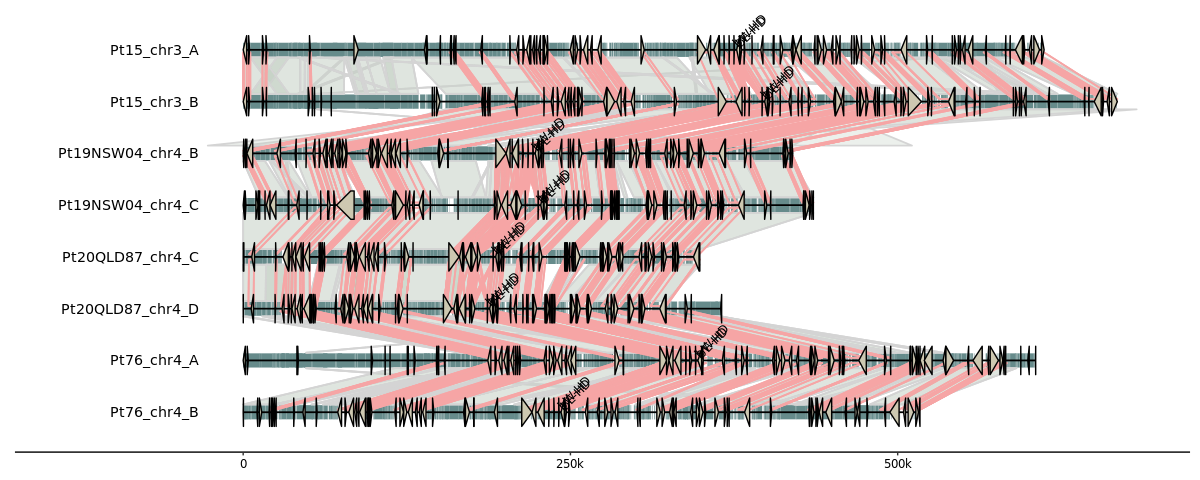

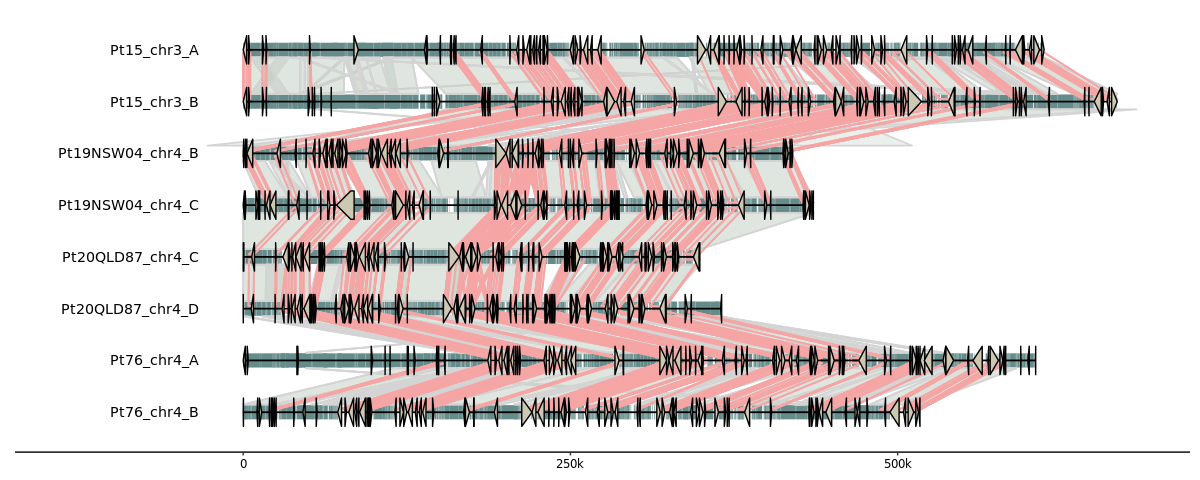

In [684]:
options(repr.plot.width=10, repr.plot.height=4)
HD_40genes<-get_flanking(Annotation_gff, HD_list$gene_id, 40)
gggenomes(HD_40genes)%>%add_links(links=HD_coords)%>%add_feats(RM_all)%>%add_sublinks(blast) +geom_feat(position="identity", linewidth=4)+
    geom_seq()+geom_link(alpha=.3, colour="grey83") +geom_link(data=links(2), colour="#f6a5a5", alpha=0.05, offset=0.05)+
    geom_gene(size=6)+ geom_bin_label()+geom_gene_tag(
  aes(label=MAT))
#HD_40genes%>%group_by(seq_id)%>%mutate(start=min(start), end=max(end))%>%select(seq_id, start, end)%>%unique()
#ggsave(file="HD_40genes_graph.svg", plot = HD_40genes_graph, width = 2100, height = 1200, units = "px" , dpi = 300)
gggenomes(HD_40genes)%>%add_links(links=HD_coords)%>%add_feats(RM_all)%>%add_sublinks(blast) +geom_feat(position="identity", linewidth=4)+
    geom_seq()+geom_link(alpha=.3, colour="grey83") +geom_link(data=links(2), colour="#f6a5a5", alpha=0.05, offset=0.05)+
    geom_gene(size=6)+ geom_bin_label()

No seqs provided, inferring seqs from feats
Transforming sublinks with "aa2nuc". Disable with `.transform = "none"`
Warning message:
“Removed 640 rows containing missing values (`geom_feat_text()`).”
No seqs provided, inferring seqs from feats
Transforming sublinks with "aa2nuc". Disable with `.transform = "none"`


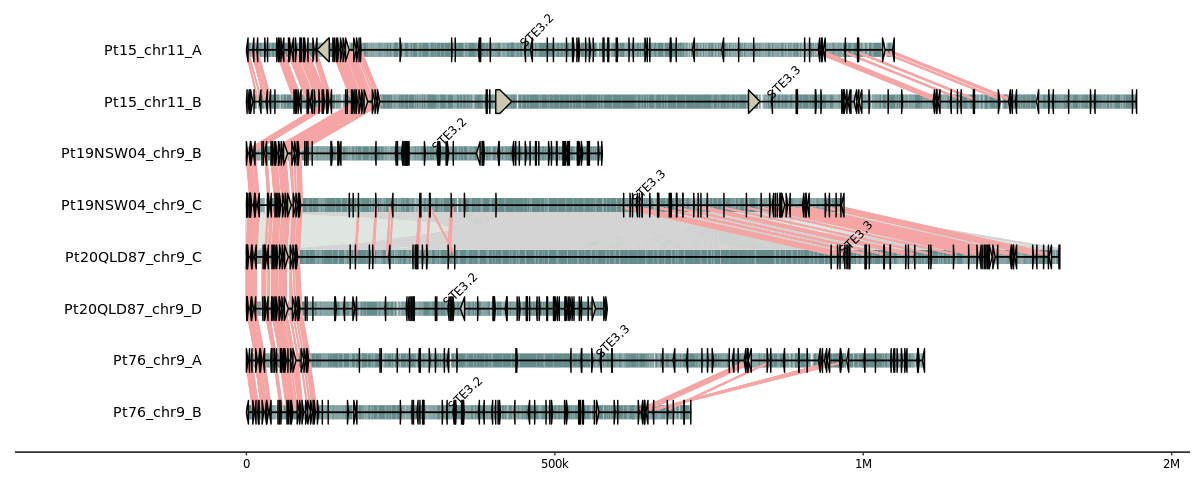

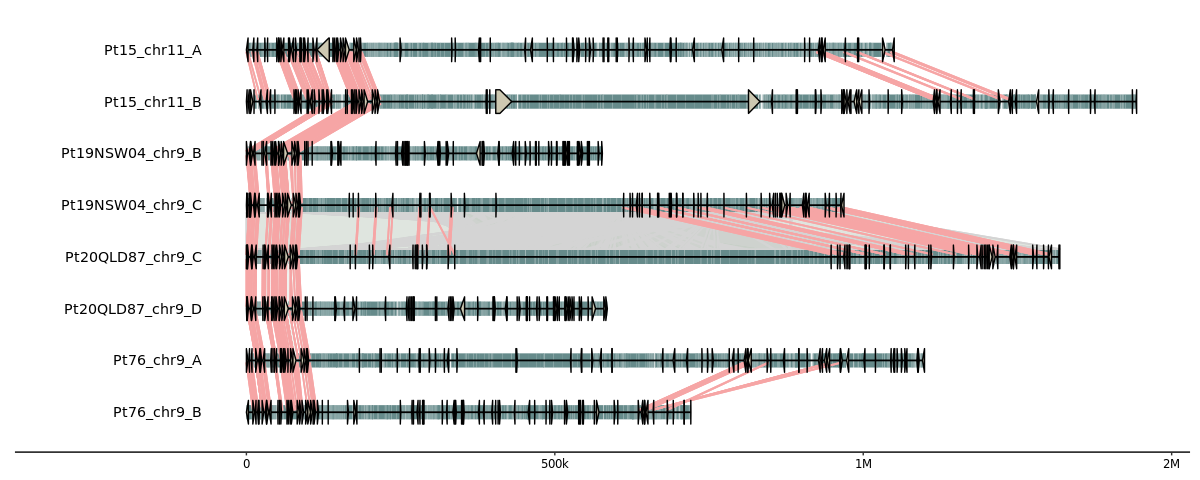

In [770]:
options(repr.plot.width=10, repr.plot.height=4)
PR_40genes<-get_flanking(Annotation_gff, PR_list$gene_id, 40)
gggenomes(PR_40genes)%>%add_links(links=PR_coords)%>%add_feats(RM_all)%>%add_sublinks(blast) +geom_feat(position="identity", linewidth=4)+
    geom_seq()+geom_link(alpha=.3, colour="grey83") +geom_link(data=links(2), colour="#f6a5a5", alpha=0.05, offset=0.05)+
    geom_gene(size=5)+ geom_bin_label()+geom_gene_tag(
  aes(label=MAT))
#HD_40genes%>%group_by(seq_id)%>%mutate(start=min(start), end=max(end))%>%select(seq_id, start, end)%>%unique()
#ggsave(file="HD_40genes_graph.svg", plot = HD_40genes_graph, width = 2100, height = 1200, units = "px" , dpi = 300)
gggenomes(PR_40genes)%>%add_links(links=PR_coords)%>%add_feats(RM_all)%>%add_sublinks(blast) +geom_feat(position="identity", linewidth=4)+
    geom_seq()+geom_link(alpha=.3, colour="grey83") +geom_link(data=links(2), colour="#f6a5a5", alpha=0.05, offset=0.05)+
    geom_gene(size=5)+ geom_bin_label()

No seqs provided, inferring seqs from feats
Transforming sublinks with "aa2nuc". Disable with `.transform = "none"`
Warning message:
“Removed 320 rows containing missing values (`geom_feat_text()`).”
No seqs provided, inferring seqs from feats
Transforming sublinks with "aa2nuc". Disable with `.transform = "none"`


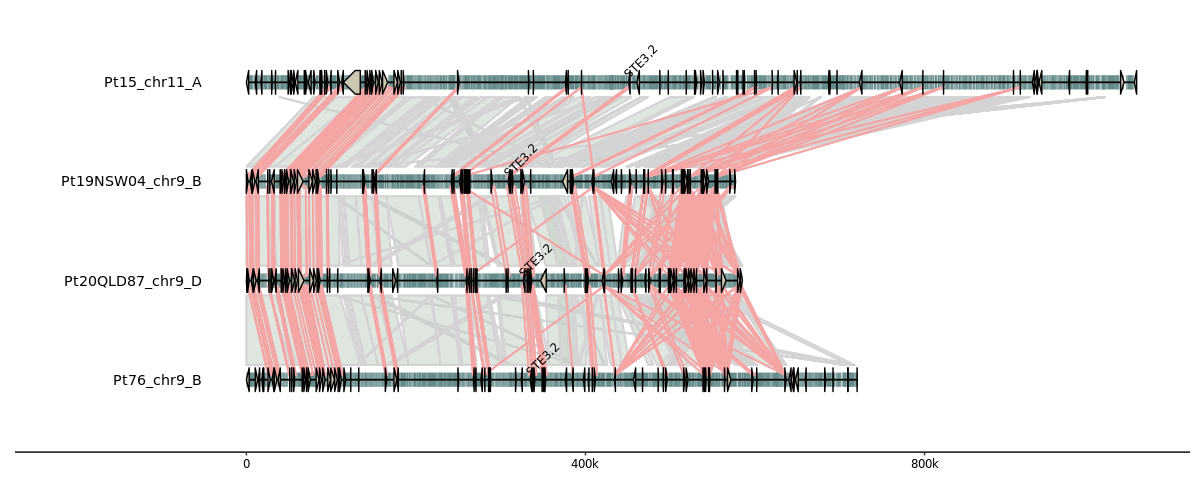

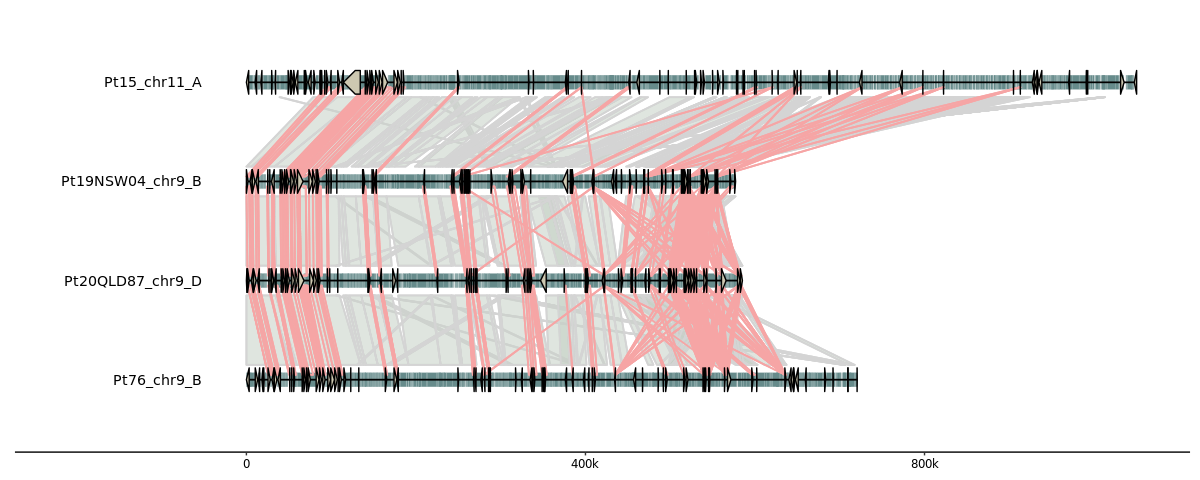

In [687]:
options(repr.plot.width=10, repr.plot.height=4)
STE32_40genes<-get_flanking(Annotation_gff, STE3.2_list$gene_id, 40)
gggenomes(STE32_40genes)%>%add_links(links=PR_coords)%>%add_feats(RM_all)%>%add_sublinks(blast) +geom_feat(position="identity", linewidth=4)+
    geom_seq()+geom_link(alpha=.3, colour="grey83") +geom_link(data=links(2), colour="#f6a5a5", alpha=0.05, offset=0.05)+
    geom_gene(size=5)+ geom_bin_label()+geom_gene_tag(
  aes(label=MAT))
#HD_40genes%>%group_by(seq_id)%>%mutate(start=min(start), end=max(end))%>%select(seq_id, start, end)%>%unique()
#ggsave(file="HD_40genes_graph.svg", plot = HD_40genes_graph, width = 2100, height = 1200, units = "px" , dpi = 300)
gggenomes(STE32_40genes)%>%add_links(links=PR_coords)%>%add_feats(RM_all)%>%add_sublinks(blast) +geom_feat(position="identity", linewidth=4)+
    geom_seq()+geom_link(alpha=.3, colour="grey83") +geom_link(data=links(2), colour="#f6a5a5", alpha=0.05, offset=0.05)+
    geom_gene(size=5)+ geom_bin_label()

No seqs provided, inferring seqs from feats
Transforming sublinks with "aa2nuc". Disable with `.transform = "none"`
Warning message:
“Removed 320 rows containing missing values (`geom_feat_text()`).”
No seqs provided, inferring seqs from feats
Transforming sublinks with "aa2nuc". Disable with `.transform = "none"`


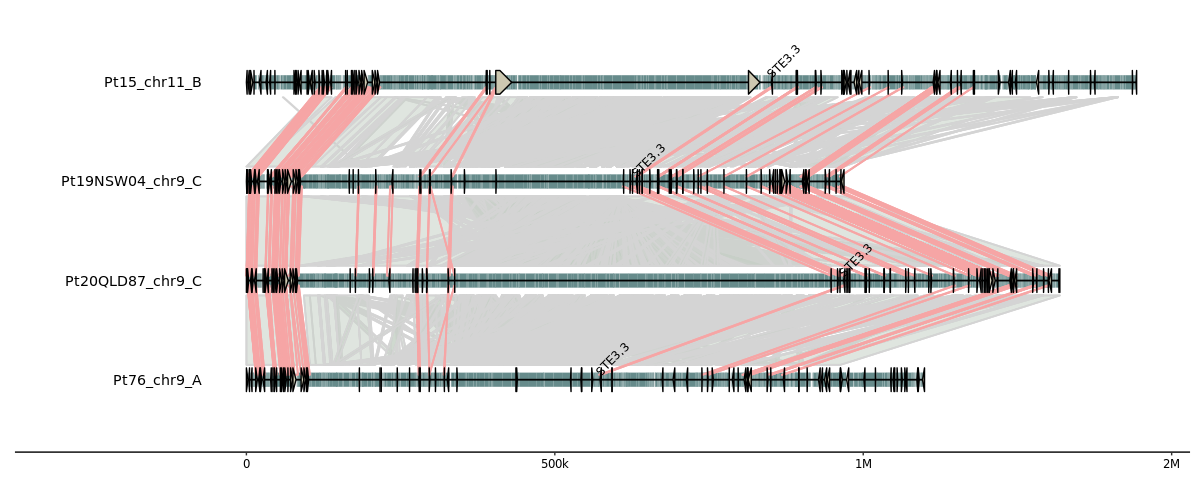

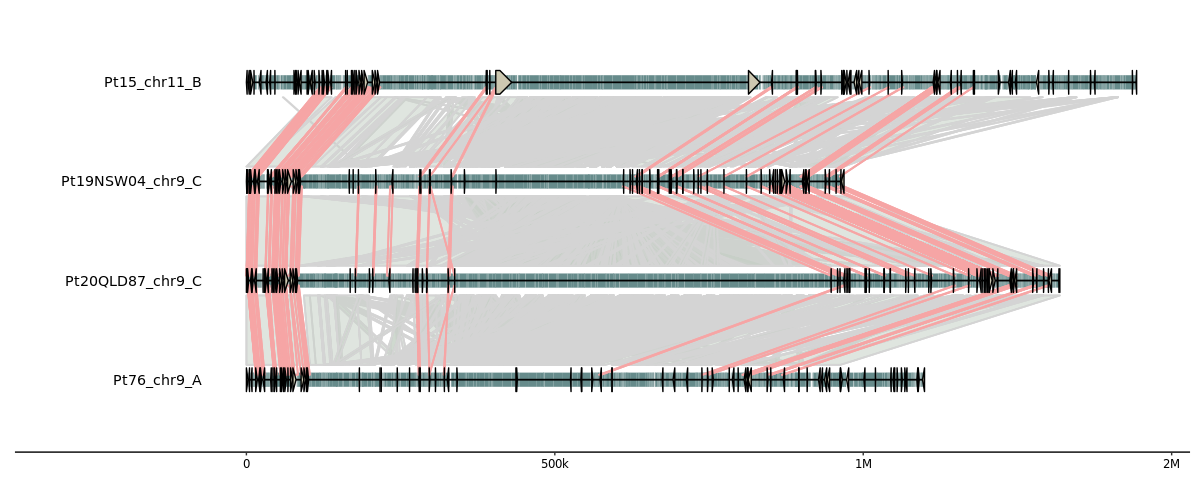

In [691]:
options(repr.plot.width=10, repr.plot.height=4)
STE33_40genes<-get_flanking(Annotation_gff, STE3.3_list$gene_id, 40)
gggenomes(STE33_40genes)%>%add_links(links=PR_coords)%>%add_feats(RM_all)%>%add_sublinks(blast) +geom_feat(position="identity", linewidth=4)+
    geom_seq()+geom_link(alpha=.3, colour="grey83") +geom_link(data=links(2), colour="#f6a5a5", alpha=0.05, offset=0.05)+
    geom_gene(size=5)+ geom_bin_label()+geom_gene_tag(
  aes(label=MAT))
#HD_40genes%>%group_by(seq_id)%>%mutate(start=min(start), end=max(end))%>%select(seq_id, start, end)%>%unique()
#ggsave(file="HD_40genes_graph.svg", plot = HD_40genes_graph, width = 2100, height = 1200, units = "px" , dpi = 300)
gggenomes(STE33_40genes)%>%add_links(links=PR_coords)%>%add_feats(RM_all)%>%add_sublinks(blast) +geom_feat(position="identity", linewidth=4)+
    geom_seq()+geom_link(alpha=.3, colour="grey83") +geom_link(data=links(2), colour="#f6a5a5", alpha=0.05, offset=0.05)+
    geom_gene(size=5)+ geom_bin_label()

In [689]:

# print value after decimal point
STE32_40genes %>% 
    group_by(seq_id) %>% 
    mutate(start = round(min(start) / 1000000, 2), end = round(max(end) / 1000000, 2)) %>% 
    select(seq_id, start, end) %>% 
    unique() %>% 
    ungroup() %>% 
    select(start) %>% 
    mutate(start = paste0(start, " Mbp"))

STE32_40genes %>% 
    group_by(seq_id) %>% 
    mutate(start = round(min(start) / 1000000, 2), end = round(max(end) / 1000000, 2)) %>% 
    select(seq_id, start, end) %>% 
    unique() %>% 
    ungroup() %>% 
    select(end) %>% 
    mutate(end = paste0(end, " Mbp"))


start
<chr>
1.4 Mbp
1.55 Mbp
1.44 Mbp
1.54 Mbp


end
<chr>
2.45 Mbp
2.13 Mbp
2.02 Mbp
2.26 Mbp


In [13]:
#Repeat analysis
#RM=repeatmasker.gff gff=gff file of annotation, gene=list of gene, flank=numbers of genes for zoom-in
get_RM_by_MAT<-function(RM, gff, gene, flank){
    region<-get_flanking(gff, gene, flank)
    region<-region%>%group_by(seq_id)%>%summarise(start=min(start), end=max(end))
    phase<-merge(RM, region, by="seq_id")%>%filter(start.x>=start.y & end.x<=end.y)%>%mutate(range=end.y-start.y)%>%select(-c(start.y, end.y))
    return(phase)
}


In [5]:
#not done yet!don't run
stat_TE<-function(test, top_value, minimium_occurance){
    test<-test%>%mutate(length=end.x -start.x)%>%mutate(parent_ids=gsub("Motif:", "", parent_ids))
    T_coverage<-test%>%mutate(coverage=(length/range)*100 )%>%group_by(seq_id,parent_ids)%>%summarize(coverage=sum(coverage))%>%arrange(seq_id, desc(coverage))
    #Print top 10 for each group, print all
    top_coverage<-T_coverage%>%group_by(seq_id)%>%top_n(5, coverage)
    #Find parent_ids which occur in all seq_id
    top_coverage%>%group_by(parent_ids)%>%filter(n()>=minimum_occurance)

}

In [705]:
reclass_REPET<-function(files){
class_if<-read.csv(files, header=TRUE)
sub_class_if_determined<-class_if%>%filter(confused=="False")%>%select(seq_name, class_classif, order_classif, Wcode)
sub_class_if_undetermined<-class_if%>%filter(confused=="True")
reclass<-sub_class_if_undetermined %>%
    select(seq_name, coding, other) %>% 
    mutate(coding = str_replace(coding, "coding=\\(", ""))%>%mutate(coding = gsub("profiles.*\\)", "", coding))%>%
    mutate(coding = str_replace(coding, ":", ""))%>%
    mutate(coding = str_replace(coding, "\\)", ""))%>%
    mutate(other=gsub("other=\\(", "",other))%>%
    mutate(other=gsub("\\)", "",other))%>%mutate(other=gsub("; TElength.*", "", other))%>%
    mutate(other=gsub("TE_BLRtx:|TE_BLRx:|profiles.*|TermRepeats.*", "", other))
for (i in 1:nrow(reclass)){
tmp_records<-reclass[i,]%>%as.data.frame()
    seq_id<-tmp_records$seq_name
    if (grepl("Class", tmp_records$coding) == TRUE){
    records<-strsplit(tmp_records$coding, "; |, ")[[1]]
    records<-data.frame(seq_id=seq_id, record=records)%>%separate(record, into=c("annotation", "identity"), sep=":(?=[^:]*$)" )
    }else{
    records<-NULL
    }
    if (grepl("Class", tmp_records$other) == TRUE){
    extra<-tmp_records$other
    extra_records<-strsplit(extra, "; |, ")[[1]]
    extra_records<-data.frame(seq_id=seq_id, record=extra_records)%>%separate(record, into=c("annotation", "identity"), sep=":(?=[^:]*$)" )    
    records<-rbind(records, extra_records)%>%
    mutate(max_identity= ifelse(max(as.numeric(gsub("%", "", identity))) >= 70 & 
    as.numeric(gsub("%", "", identity)) == max(as.numeric(gsub("%", "", identity))), max(as.numeric(gsub("%", "", identity))), NA))%>%drop_na(max_identity)
    }else if (grepl("Class", tmp_records$coding) == TRUE){
    records<-records%>%group_by(seq_id)%>%
    mutate(max_identity= ifelse(max(as.numeric(gsub("%", "", identity))) >= 70 & 
    as.numeric(gsub("%", "", identity)) == max(as.numeric(gsub("%", "", identity))), max(as.numeric(gsub("%", "", identity))), NA))%>%drop_na(max_identity)
    }else{
    records<-NULL
    }
    if (!is.null(records) && nrow(records) > 0){
       records<-records%>%mutate(annotation=gsub(".*Class", "Class", annotation))
    }else{
     records<-data.frame(seq_id=seq_id, annotation="Undetermined", identity=NA, max_identity=NA)
    }
    if(i == 1){
        records_new<-records
    }else{
        records_new<-rbind(records_new, records)
    }
}
records_new<-records_new %>%
  separate(annotation, into = c("Class", "Order","WCode"), sep = ":", fill = "right")%>%
  mutate(Order=ifelse(Order=="?", paste0("Undetermined ", Class), Order))%>% 
  select("seq_id","Class","Order","WCode")
colnames(records_new)<-c("seq_name","class_classif","order_classif","Wcode")
sub_class_if_undetermined<-records_new
class_RM<-rbind(sub_class_if_determined, sub_class_if_undetermined)%>%mutate(order_classif=ifelse(order_classif=="Unclassified" & 
    class_classif!="Unclassified", paste0("Undetermined ", class_classif ), order_classif))%>%
    mutate(order_classif = ifelse(is.na(order_classif)& !is.na(class_classif), paste0("Undetermined ", class_classif ), order_classif))%>%
    mutate(order_classif=ifelse(is.na(class_classif) & !is.na(Wcode), Wcode, order_classif))
colnames(class_RM)<-c("parent_ids", "class", "order", "Wcode")
class_RM<-class_RM%>%mutate(order = ifelse(order == "Unclassified" | order == "NA", "Undetermined", order))%>%
    mutate(order = gsub("Class", "", order))%>%mutate(order = gsub("Undetermined Undetermined", "Undetermined", order))
#reorder class_RM
class_RM <- class_RM[match(class_if$seq_name, class_RM$parent_ids), ]
return(class_RM)
}
class_RM<-reclass_REPET("repeatmasker/Pt76_sim_consensus_classif.csv")


Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 2 rows [2, 3].”
Warning message:
“There were 3 warnings in `mutate()`.
The first warning was:
ℹ In argument: `max_identity = ifelse(...)`.
Caused by warning in `ifelse()`:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 2 remaining warnings.”
Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 2 rows [2, 3].”
Warning message:
“There were 3 warnings in `mutate()`.
The first warning was:
ℹ In argument: `max_identity = ifelse(...)`.
Caused by warning in `ifelse()`:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 2 remaining warnings.”


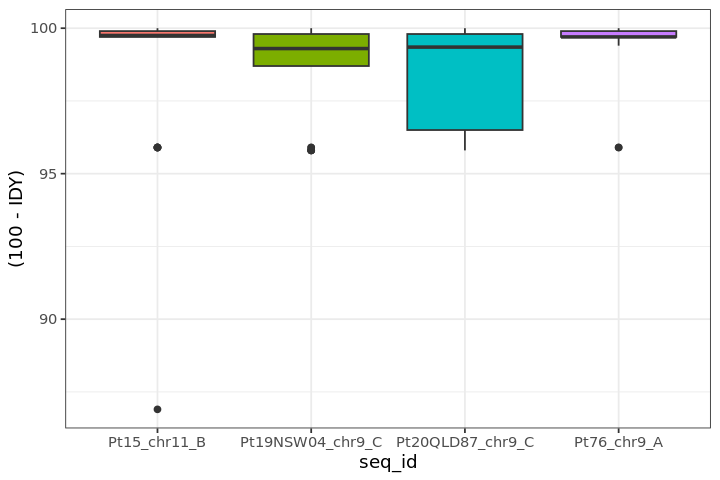

In [727]:
options(repr.plot.width=6, repr.plot.height=4)
IDY_R2587<-get_RM_by_MAT(RM_all, Annotation_gff, STE3.3_list$gene_id, 40)%>%
filter(parent_ids=="Motif:Pt76-B-R2587-Map20")%>%mutate(length=end.x-start.x)%>%
select(seq_id, start.x, end.x, strand,IDY,length)%>%ungroup()
#Plot boxplot of IDY
ggplot(IDY_R2587, aes(x=seq_id, y=(100-IDY), fill=seq_id)) + geom_boxplot() + theme_bw() + theme(legend.position="none") 
IDY_R2587_plot<-ggplot(IDY_R2587, aes(x=seq_id, y=(100-IDY), fill=seq_id)) + geom_boxplot() + theme_bw() + theme(legend.position="none") 
ggsave(file="IDY_R2587_plot.svg", plot = IDY_R2587_plot, width = 2000, height = 800, units = "px" , dpi = 300)
#ggplot(IDY_R2587, aes(x=seq_id, fill=seq_id)) + geom_histogram(binwidth=1, position="identity", alpha=0.5) + facet_wrap(~seq_id, ncol=4) + theme_bw() + theme(legend.position="none")

In [760]:
options(repr.plot.width=6, repr.plot.height=4)
LEN_R2587<-get_RM_by_MAT(RM_all, Annotation_gff, STE3.3_list$gene_id, 40)%>%
filter(parent_ids=="Motif:Pt76-B-R2587-Map20")%>%mutate(length=end.x-start.x)%>%
select(seq_id, start.x, end.x, strand,IDY,length)%>%ungroup()
LEN_R2587_plot<-ggplot(LEN_R2587, aes(x=seq_id, y=length, fill=seq_id)) + 
    geom_boxplot() + 
    theme_bw() + 
    theme(legend.position="none")
ggsave(file="LEN_R2587_plot.svg", plot = LEN_R2587_plot, width = 2000, height = 800, units = "px" , dpi = 300)

In [285]:
#calculate the covergae of repeat on each chromosome
Genome.size<-read.table("Pt.genomesize")
colnames(Genome.size)<-c("seq_id", "chr_size")
# calculate the coverage of repeat on each chromosome
Genome.size <- read.table("Pt.genomesize")
colnames(Genome.size) <- c("seq_id", "chr_size")
Genome.size<-Genome.size%>%filter(seq_id %in% grep("chr", seq_id, value = TRUE))

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `is.na(length) == 0`.
Caused by warning in `is.na()`:
! is.na() applied to non-(list or vector) of type 'builtin'”
Warning message:
“Removed 11 rows containing missing values (`position_stack()`).”
Warning message:
“Removed 10 rows containing missing values (`position_stack()`).”
Warning message:
“Removed 10 rows containing missing values (`position_stack()`).”
Warning message:
“Removed 10 rows containing missing values (`position_stack()`).”


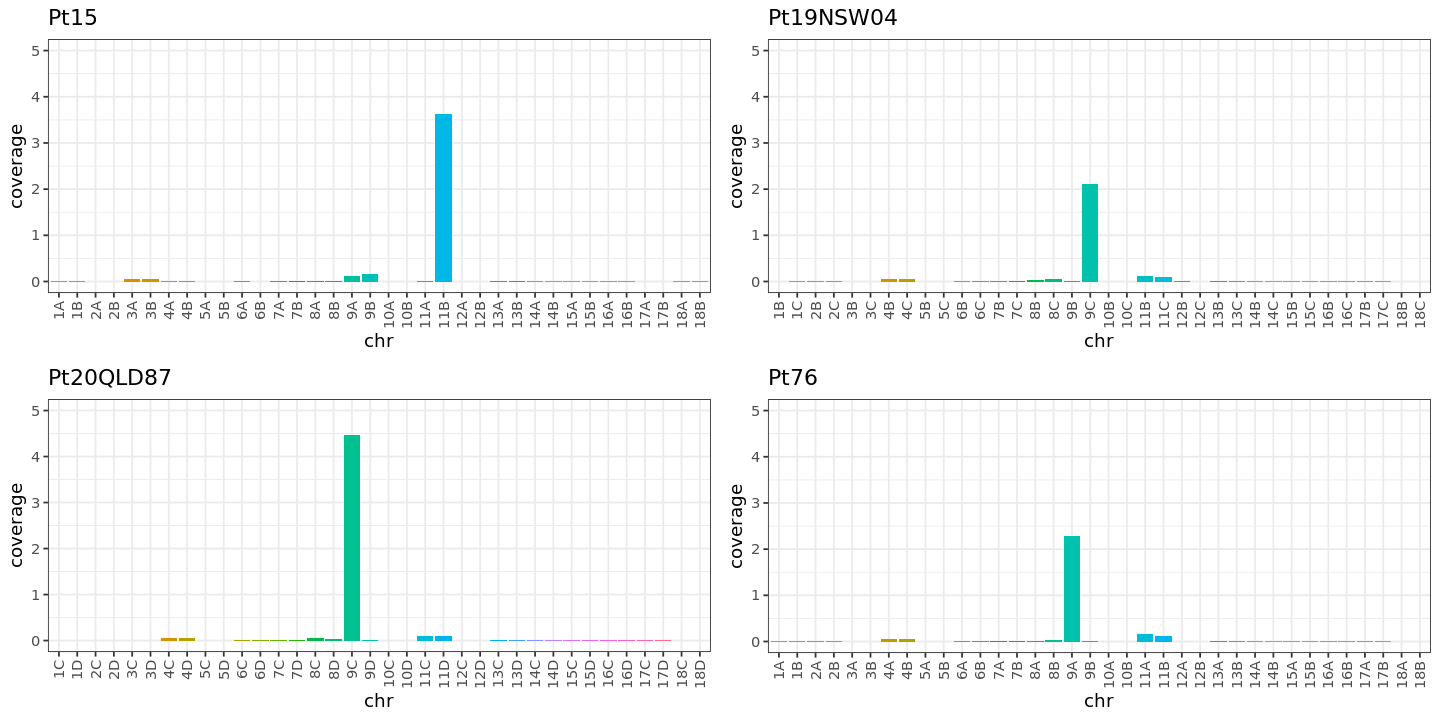

In [308]:

R2587.covgenome<-RM_all%>%
    filter(parent_ids == "Motif:Pt76-B-R2587-Map20") %>%
    arrange(seq_id)%>%
    mutate(length = end - start)%>%select(seq_id, length)%>%
    group_by(seq_id)%>%summarise(total_length=sum(length))
R2587.covgenome<-merge(Genome.size, R2587.covgenome, by = "seq_id", all.x = TRUE)%>%
    mutate(is.na(length)==0)%>%
    mutate(coverage=(total_length/chr_size)*100)%>%
    select(seq_id, coverage)%>%as.data.frame()
R2587.covgenome$strain <- str_split(R2587.covgenome$seq_id, "_", simplify = TRUE)[,1]
R2587.covgenome$seq_id <- str_replace(R2587.covgenome$seq_id, "_A", "A")
R2587.covgenome$seq_id <- str_replace(R2587.covgenome$seq_id, "_B", "B")
R2587.covgenome$seq_id <- str_replace(R2587.covgenome$seq_id, "_C", "C")
R2587.covgenome$seq_id <- str_replace(R2587.covgenome$seq_id, "_D", "D")
R2587.covgenome$chr <-str_split(R2587.covgenome$seq_id, "_", simplify = TRUE)[,2]
R2587.covgenome$chr <-str_replace(R2587.covgenome$chr, "chr", "")
#print coverage of repeat on each chromosome, subgroup with strain 
R2587.covgenome<-arrange(R2587.covgenome, strain, chr)
#print 1A,1B...to 18A, 18B a vector

for (i in full_name){
    R2587.covgenome_sub<-R2587.covgenome%>%filter(strain==i)
    if (i != "Pt19NSW04" & i != "Pt20QLD87"){
        chr<-c()
        for (c in 1:18){
        chr<-c(chr, paste0(c, "A"))
        chr<-c(chr, paste0(c, "B"))
        }
        R2587.covgenome_sub$chr<-factor(R2587.covgenome_sub$chr, levels=chr)
    plot<-ggplot(R2587.covgenome_sub, aes(x=chr, y=coverage, fill=chr)) + geom_bar(stat="identity") +  ylim(0, 5) +theme_bw() + theme(legend.position="none",axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + ggtitle(i)
    }else if (i == "Pt19NSW04"){
        chr<-c()
        for (c in 1:18){
        chr<-c(chr, paste0(c, "B"))
        chr<-c(chr, paste0(c, "C"))
        }
        R2587.covgenome_sub$chr<-factor(R2587.covgenome_sub$chr, levels=chr)
    plot<-ggplot(R2587.covgenome_sub, aes(x=chr, y=coverage, fill=chr)) + geom_bar(stat="identity") +  ylim(0, 5) +theme_bw() + theme(legend.position="none",axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + ggtitle(i)
    }else if (i == "Pt20QLD87"){
        chr<-c()
        for (c in 1:18){
        chr<-c(chr, paste0(c, "C"))
        chr<-c(chr, paste0(c, "D"))
        }
        R2587.covgenome_sub$chr<-factor(R2587.covgenome_sub$chr, levels=chr)
    plot<-ggplot(R2587.covgenome_sub, aes(x=chr, y=coverage, fill=chr)) + geom_bar(stat="identity") + ylim(0, 5) +theme_bw() + theme(legend.position="none",axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + ggtitle(i)
    }
    #append plot
    assign(paste0(i, "_cov_genome_plot"), plot)
}
#order the plot and print with ggpubr
options(repr.plot.width=12, repr.plot.height=6)
cov_genome_plot<-ggarrange(Pt15_cov_genome_plot, Pt19NSW04_cov_genome_plot, Pt20QLD87_cov_genome_plot, Pt76_cov_genome_plot, nrow=2, ncol=2)
#save plot
cov_genome_plot
ggsave(file="cov_genome_plot.svg", plot = cov_genome_plot, width = 1700, height = 1000, units = "px" , dpi = 300)


`summarise()` has grouped output by 'seq_id'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'seq_id'. You can override using the `.groups` argument.


seq_id,parent_ids,coverage
<chr>,<chr>,<dbl>
Pt15_chr11_A,Pt76-B-R8118-Map3,7.3
Pt15_chr11_A,Pt76-B-R16595-Map3,5.9
Pt15_chr11_A,Pt76-B-R430-Map20,2.4
Pt15_chr11_A,Pt76-B-R2435-Map20_reversed,2.4
Pt15_chr11_A,Pt76-B-P144.32-Map5,1.8
Pt19NSW04_chr9_B,Pt76-B-G11980-Map13,3.2
Pt19NSW04_chr9_B,Pt76-B-R16595-Map3,3.1
Pt19NSW04_chr9_B,Pt76-B-R8118-Map3,2.3
Pt19NSW04_chr9_B,Pt76-B-G1205-Map20_reversed,1.8


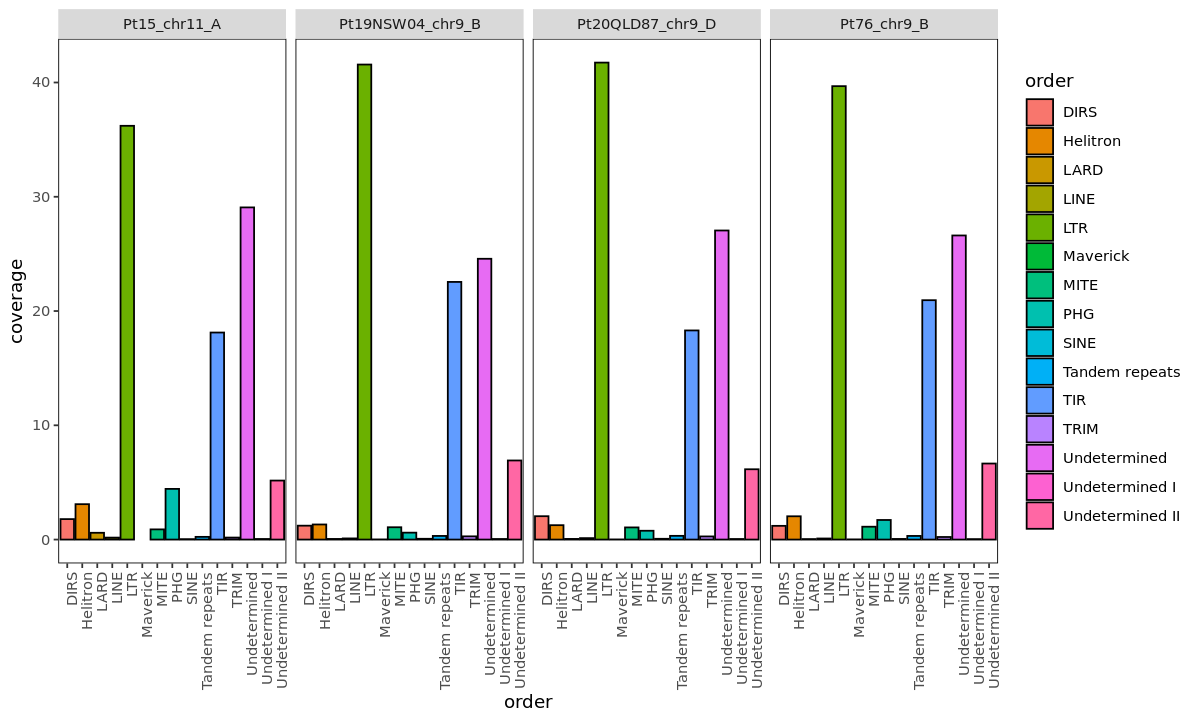

In [776]:
STE3.2_RM <- get_RM_by_MAT(RM_all, Annotation_gff, STE3.2_list$gene_id, 40)
# Now sort by chr, then start, IDY
STE3.2_RM <- STE3.2_RM %>% arrange(seq_id, start.x, IDY)%>% 
    mutate(length = end.x - start.x) %>% mutate(parent_ids = gsub("Motif:", "", parent_ids))
STE3.2_RM <- merge(STE3.2_RM, class_RM, by = "parent_ids", all = TRUE) %>% drop_na(seq_id) %>% arrange(seq_id, start.x, IDY) %>% mutate(parent_ids = as.character(parent_ids))
STE3.2_RM <- STE3.2_RM %>% mutate(order = ifelse(grepl("\\)n", parent_ids), "Tandem repeats", order))%>%drop_na(order)
STE3.2_RM <-STE3.2_RM%>%mutate(order=ifelse(order == "Unclassified", "Undetermined", order))
T_coverage <- STE3.2_RM%>% mutate(coverage = (length / range) * 100) %>% group_by(seq_id, order) %>% summarize(coverage = sum(coverage)) %>% arrange(seq_id, desc(coverage))

# Create the barplot
options(repr.plot.width=10, repr.plot.height=6)
STE3.2_RM_plot<-ggplot(T_coverage, aes(x = order, y = coverage, fill = order)) +
    geom_bar(stat = "identity", color = "black") +
    facet_wrap(~seq_id, ncol = 4) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1),panel.background = element_rect(fill = "white"),
    panel.border = element_rect(color = "black", fill = NA),legend.key=element_blank())
STE3.2_RM %>% mutate(coverage = (length / range) * 100) %>% group_by(seq_id, parent_ids) %>% summarize(coverage = sum(coverage))%>%top_n(5, coverage)%>%arrange(seq_id, desc(coverage))
ggsave("Pt_STE32_locus_TEcov.svg", plot =STE3.2_RM_plot,  width=3000, height=2000, units="px", dpi=300)
STE3.2_RM_plot

`summarise()` has grouped output by 'seq_id'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'seq_id'. You can override using the `.groups` argument.


seq_id,parent_ids,coverage
<chr>,<chr>,<dbl>
Pt15_chr11_B,Pt76-B-R2587-Map20,17.7
Pt15_chr11_B,Pt76-B-G955-Map9_reversed,2.6
Pt15_chr11_B,Pt76-B-P144.32-Map5,2.0
Pt15_chr11_B,Pt76-B-G11781-Map3,1.5
Pt15_chr11_B,Pt76-B-P310.32-Map4,1.4
Pt19NSW04_chr9_C,Pt76-B-R2587-Map20,15.2
Pt19NSW04_chr9_C,Pt76-B-G11958-Map14,4.1
Pt19NSW04_chr9_C,Pt76-B-P1266.134-Map4,2.3
Pt19NSW04_chr9_C,Pt76-B-P144.32-Map5,2.2


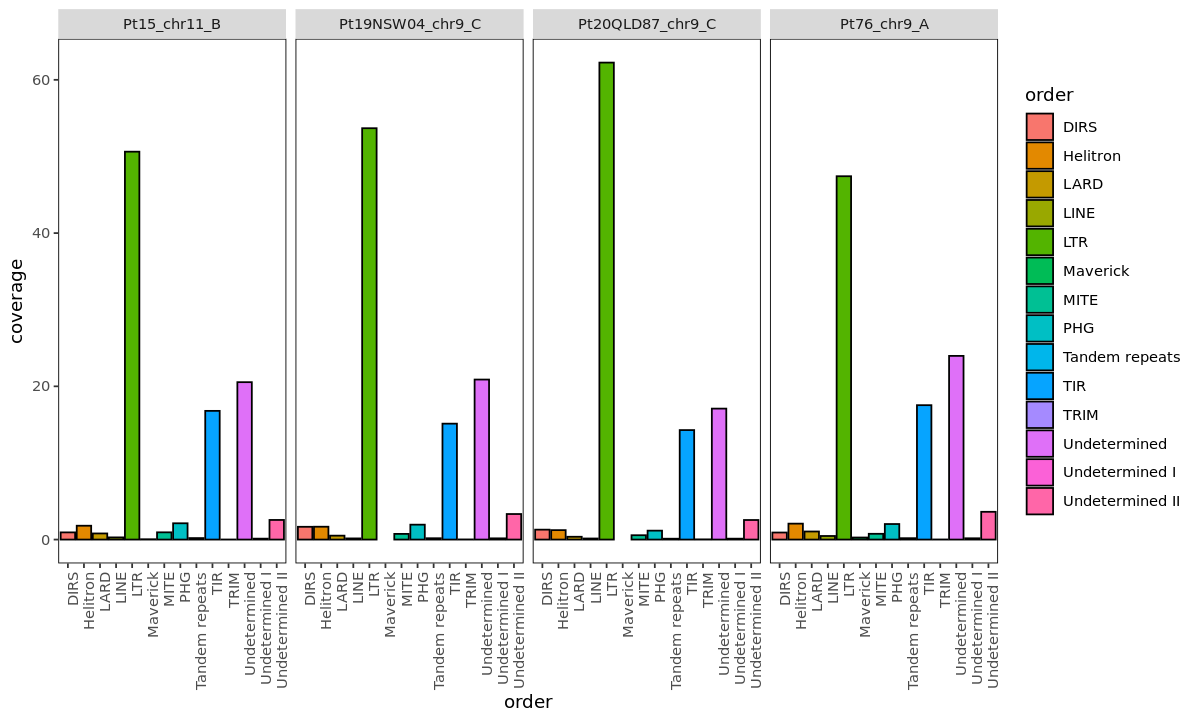

In [775]:
STE3.3_RM <- get_RM_by_MAT(RM_all, Annotation_gff, STE3.3_list$gene_id, 40)
# Now sort by chr, then start, IDY
STE3.3_RM <- STE3.3_RM %>% arrange(seq_id, start.x, IDY)%>% 
    mutate(length = end.x - start.x) %>% mutate(parent_ids = gsub("Motif:", "", parent_ids))
STE3.3_RM <- merge(STE3.3_RM, class_RM, by = "parent_ids", all = TRUE) %>% drop_na(seq_id) %>% arrange(seq_id, start.x, IDY) %>% mutate(parent_ids = as.character(parent_ids))
STE3.3_RM <- STE3.3_RM %>% mutate(order = ifelse(grepl("\\)n", parent_ids), "Tandem repeats", order))%>%drop_na(order)
STE3.3_RM <-STE3.3_RM%>%mutate(order=ifelse(order == "Unclassified", "Undetermined", order))
T_coverage <- STE3.3_RM%>% mutate(coverage = (length / range) * 100) %>% group_by(seq_id, order) %>% summarize(coverage = sum(coverage)) %>% arrange(seq_id, desc(coverage))

# Create the barplot
options(repr.plot.width=10, repr.plot.height=6)
STE3.3_RM_plot<-ggplot(T_coverage, aes(x = order, y = coverage, fill = order)) +
    geom_bar(stat = "identity", color = "black") +
    facet_wrap(~seq_id, ncol = 4) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1),panel.background = element_rect(fill = "white"),
    panel.border = element_rect(color = "black", fill = NA),legend.key=element_blank())
STE3.3_RM %>% mutate(coverage = (length / range) * 100) %>% group_by(seq_id, parent_ids) %>% summarize(coverage = sum(coverage))%>%top_n(5, coverage)%>%arrange(seq_id, desc(coverage))
ggsave("Pt_STE33_locus_TEcov.svg", plot =STE3.3_RM_plot,  width=3000, height=2000, units="px", dpi=300)
STE3.3_RM_plot

`summarise()` has grouped output by 'seq_id'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'seq_id'. You can override using the `.groups` argument.


seq_id,parent_ids,coverage
<chr>,<chr>,<dbl>
Pt15_chr3_A,Pt76-B-R988-Map5_reversed,2.8
Pt15_chr3_A,Pt76-B-G11986-Map13_reversed,2.5
Pt15_chr3_A,Pt76-B-R6051-Map20,2.1
Pt15_chr3_A,Pt76-B-R987-Map20,2.1
Pt15_chr3_A,Pt76-B-G11976-Map3_reversed,2.0
Pt15_chr3_B,Pt76-B-R988-Map5_reversed,2.5
Pt15_chr3_B,Pt76-B-G12108-Map4_reversed,2.5
Pt15_chr3_B,Pt76-B-G11986-Map13_reversed,2.5
Pt15_chr3_B,Pt76-B-R5539-Map4,2.1


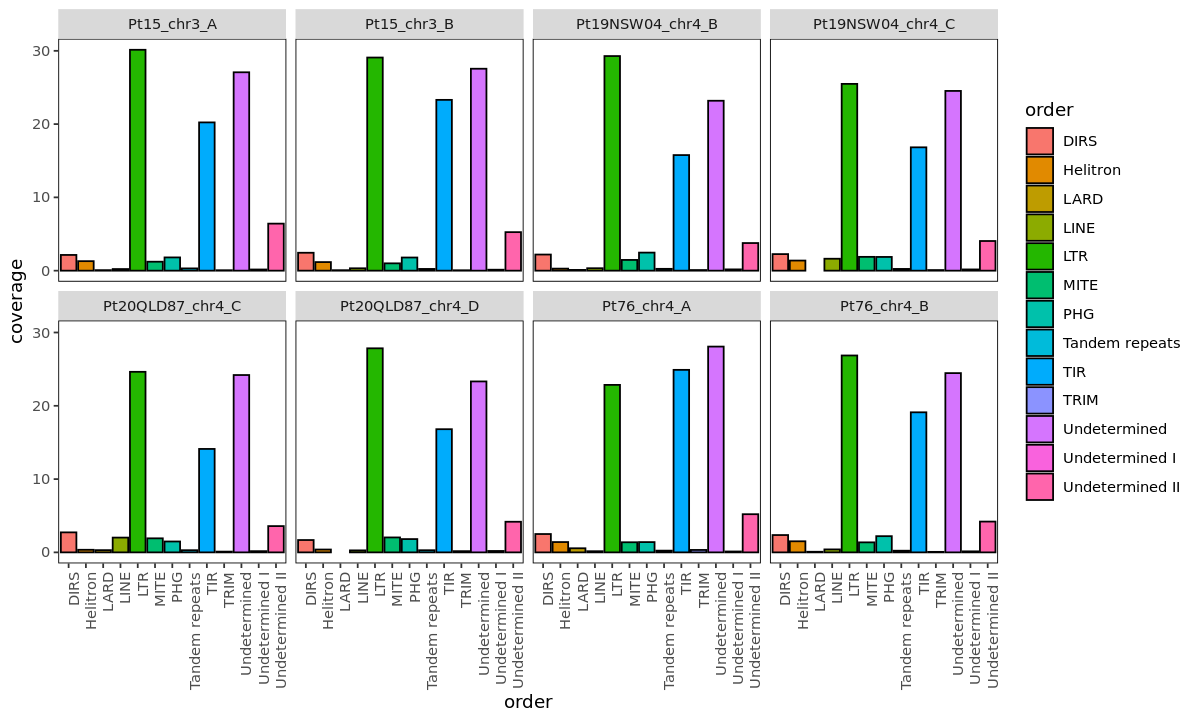

In [777]:
HD_RM <- get_RM_by_MAT(RM_all, Annotation_gff, HD_list$gene_id, 40)
# Now sort by chr, then start, IDY
HD_RM <- HD_RM %>% arrange(seq_id, start.x, IDY)%>% 
    mutate(length = end.x - start.x) %>% mutate(parent_ids = gsub("Motif:", "", parent_ids))
HD_RM <- merge(HD_RM, class_RM, by = "parent_ids", all = TRUE) %>% drop_na(seq_id) %>% arrange(seq_id, start.x, IDY) %>% mutate(parent_ids = as.character(parent_ids))
HD_RM <- HD_RM %>% mutate(order = ifelse(grepl("\\)n", parent_ids), "Tandem repeats", order))%>%drop_na(order)
HD_RM <-HD_RM%>%mutate(order=ifelse(order == "Unclassified", "Undetermined", order))
T_coverage <- HD_RM%>% mutate(coverage = (length / range) * 100) %>% group_by(seq_id, order) %>% summarize(coverage = sum(coverage)) %>% arrange(seq_id, desc(coverage))

# Create the barplot
options(repr.plot.width=10, repr.plot.height=6)
HD_RM_plot<-ggplot(T_coverage, aes(x = order, y = coverage, fill = order)) +
    geom_bar(stat = "identity", color = "black") +
    facet_wrap(~seq_id, ncol = 4) +
    theme(axis.text.x = element_text(angle = 90, hjust = 1),panel.background = element_rect(fill = "white"),
    panel.border = element_rect(color = "black", fill = NA),legend.key=element_blank())
HD_RM %>% mutate(coverage = (length / range) * 100) %>% group_by(seq_id, parent_ids) %>% summarize(coverage = sum(coverage))%>%top_n(5, coverage)%>%arrange(seq_id, desc(coverage))
ggsave("Pt_HD_locus_TEcov.svg", plot =HD_RM_plot,  width=3000, height=2000, units="px", dpi=300)
HD_RM_plot

No seqs provided, inferring seqs from feats


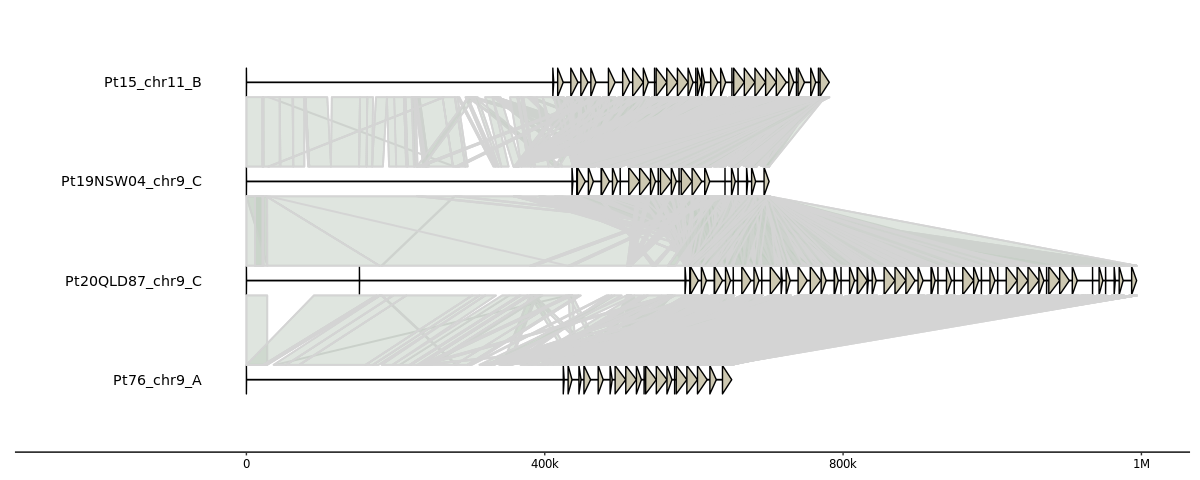

In [182]:
test2<-get_RM_by_MAT(RM_all, Annotation_gff, STE3.3_list$gene_id, 160)%>%
filter(parent_ids=="Motif:Pt76-B-R2587-Map20")%>%mutate(type="CDS")%>%
select(seq_id,type,  start.x, end.x, strand,feat_id)%>%ungroup()
colnames(test2)<-c("seq_id", "type", "start", "end", "strand", "feat_id")
gggenomes(test2)%>%add_links(links=STE3.3_coords)+geom_seq()+geom_gene(size=6)+ geom_bin_label()+geom_link(alpha=.3, colour="grey83")